In [1]:
from block_methods import *
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker, cm
import matplotlib.colors as colors
from scipy import integrate
import json

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['text.latex.preamble'] = r'\usepackage{newtxtext,newtxmath}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis([0, 0.6, 0.8]))

In [3]:
n = 500 # matrix dimension
b = 4 # block size
step = 5
thresh = 1e-4

# set up matrix
λ1 = 1e-3
λn = 1
ρ=0.9
Λ = λ1+np.arange(n)/(n-1)*(λn-λ1)*ρ**(n-(np.arange(n)+1))
H = np.diag(Λ)

λmin = np.min(Λ)
λmax = np.max(Λ)

f = lambda x: 1/np.sqrt(x)

Kros = [(30,31),(60,0)] # max iter
w = λmin/100

angle = .99*np.pi # angle for D contour
r = 2 # radius for D contour
lim = 10
np.random.seed(0)

hnorm = get_hnorm(Λ, lambda Λ: Λ-w)

In [4]:
error_FAr = []
error_wLSr = []
error_absr = []
error_fullr = []

V = np.random.randn(n,b)

for K,reorth in Kros:

    # run Lanczos
    Q,Qkp1,A,B,B_0 = block_lanczos(H, V, K, reorth)

    # generate tridiagonal matrix
    T = get_block_tridiag(A,B)

    fAV = np.diag(f(Λ))@V

    error_FA = np.full(K,np.nan)
    error_wLS = np.full(K,np.nan)
    error_abs = np.full(K,np.nan)
    error_full = np.full(K,np.nan)
    
    for k in range(1,K): 

        T = get_block_tridiag(A[:k],B[:k])
        Eval,Evec = np.linalg.eigh(T)

        error_wLS[k] = hnorm(np.diag(1/(Λ-w))@V - get_lan_wLS(Eval, Evec, b, B_0, w, Q, k))

        lanf = Q[:,:b*k]@(Evec@np.diag(f(Eval))@Evec.T@Ei(b*k,b,1)@B_0)
        error_FA[k] = hnorm(fAV - lanf)
        
        pts = np.logspace(-15, -1, lim)

        error_abs[k] = get_trig_ineq_bound(pts, angle, r, Eval, Evec, b, B_0, λmin, f, w, Λ, V, Q, k, hnorm)
        error_full[k] = get_a_posteriori_bound(pts, angle, r, Eval, Evec, b, B_0, λmin, f, w, w, λmax)

    error_FAr.append(error_FA)
    error_wLSr.append(error_wLS)
    error_absr.append(error_abs)
    error_fullr.append(error_full)

c:\Users\qcx\work\code\block_lanczos_CIF\block_methods\block_methods.py:391: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result += sp.integrate.quad(a_posteriori_bound_integrand, 0, 1, args=(Γl, angle, r, Eval, Evec, b, B_0, λmin, f, c, w, λmax), points = pts)[0]
c:\Users\qcx\work\code\block_lanczos_CIF\block_methods\block_methods.py:390: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local diff

In [5]:
with open('data/figure_3.8/error_FAr_fp.json', 'w') as json_file:
    json.dump([arr.tolist() for arr in error_FAr], json_file)
with open('data/figure_3.8/error_wLSr_fp.json', 'w') as json_file:
    json.dump([arr.tolist() for arr in error_wLSr], json_file)
with open('data/figure_3.8/error_absr_fp.json', 'w') as json_file:
    json.dump([arr.tolist() for arr in error_absr], json_file)
with open('data/figure_3.8/error_fullr_fp.json', 'w') as json_file:
    json.dump([arr.tolist() for arr in error_fullr], json_file)

# Uncomment the cell below to generate figures directly from data. 

In [6]:
# with open('data/figure_3.8/error_FAr_fp.json', 'r') as json_file:
#     loaded_data = json.load(json_file)
# error_FAr = [np.array(arr) for arr in loaded_data]
# with open('data/figure_3.8/error_wLSr_fp.json', 'r') as json_file:
#     loaded_data = json.load(json_file)
# error_wLSr = [np.array(arr) for arr in loaded_data]
# with open('data/figure_3.8/error_absr_fp.json', 'r') as json_file:
#     loaded_data = json.load(json_file)
# error_absr = [np.array(arr) for arr in loaded_data]
# with open('data/figure_3.8/error_fullr_fp.json', 'r') as json_file:
#     loaded_data = json.load(json_file)
# error_fullr = [np.array(arr) for arr in loaded_data]

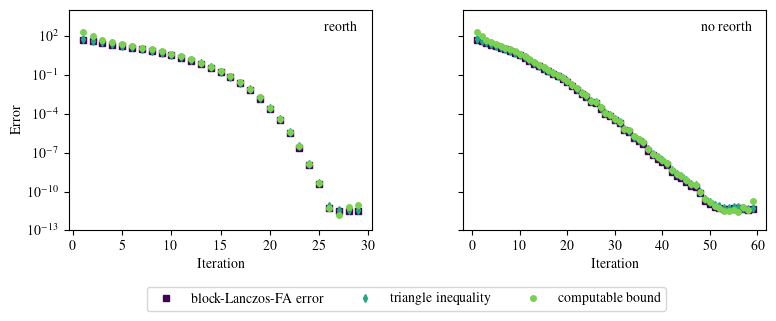

In [7]:
fig, axes = plt.subplots(1,2, figsize=(9,3.5), sharey = True)
fig.subplots_adjust(wspace=.3,bottom=0.25)

for i in range(2):
    axes[i].plot(error_FAr[i], ls='None', ms=4, marker = 's', label = 'block-Lanczos-FA error')
    axes[i].plot(error_absr[i],ls='None', ms=4, marker = 'd', label = 'triangle inequality')
    axes[i].plot(error_fullr[i]*error_wLSr[i],ls='None' , ms=4, marker = 'o', label = 'computable bound')
        
        
    axes[i].set_yscale('log')
    axes[i].set_xlabel('Iteration')
    
    axes[i].set_ylim(1e-13,1e4)
    
axes[0].set_ylabel('Error')
axes[0].text(.95,.95,'reorth',ha='right', va='top', transform=axes[0].transAxes,bbox=dict(facecolor='white',edgecolor='none',pad=2))
axes[1].text(.95,.95,'no reorth',ha='right', va='top', transform=axes[1].transAxes,bbox=dict(facecolor='white',edgecolor='none',pad=2))

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0),ncol=3)

plt.savefig("imgs/figure_3.8.pdf")